# Micrograd

Micrograd is an automatic gradient engine that implements backpropagation to tune the weights of small neural networks.

In [1]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt

import torch

## Derivatives Review

In [2]:
# defining a function
def f(x):
    return 3*x**2 - 4*x + 5

print(f(3.0))

20.0


xs
[-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75]

ys
[100.      91.6875  83.75    76.1875  69.      62.1875  55.75    49.6875
  44.      38.6875  33.75    29.1875  25.      21.1875  17.75    14.6875
  12.       9.6875   7.75     6.1875   5.       4.1875   3.75     3.6875
   4.       4.6875   5.75     7.1875   9.      11.1875  13.75    16.6875
  20.      23.6875  27.75    32.1875  37.      42.1875  47.75    53.6875]



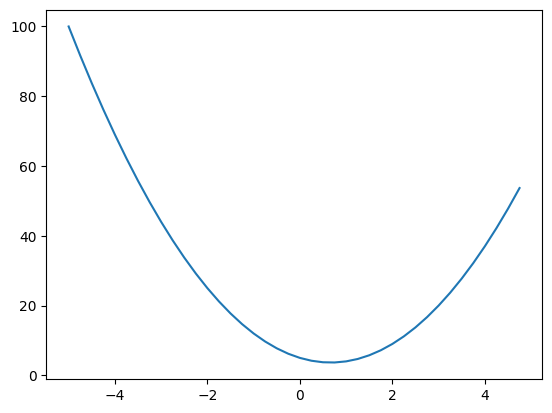

In [3]:
# testing and plotting function
xs = np.arange(-5, 5, 0.25)
print('xs')
print(xs)
print()
ys = f(xs)
print('ys')
print(ys)
print()
plt.plot(xs, ys);

In [4]:
# change in x
h = np.logspace(start=-2, stop=-8, num=7, base=10.0)
print(h)

[1.e-02 1.e-03 1.e-04 1.e-05 1.e-06 1.e-07 1.e-08]


In [5]:
# exploring the function's instantaneous change in slope (derivative) at 3
x = 3.0
dxdh = (f(x+h)-f(x))/h
print(dxdh)

[14.03       14.003      14.0003     14.00003    14.000003   14.00000031
 14.00000009]


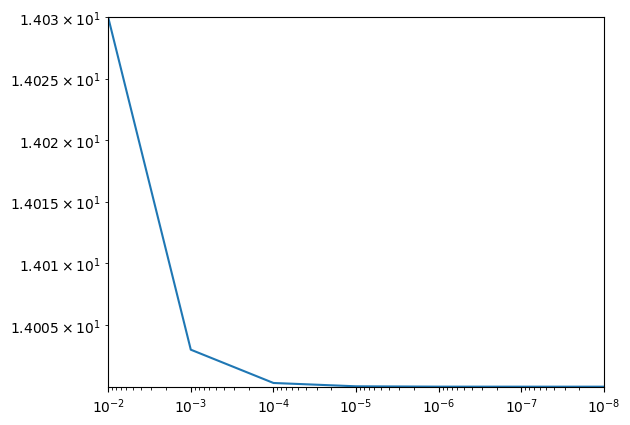

In [6]:
# plotting function's derivative at 3
plt.plot(h, dxdh)
plt.xscale('log')
plt.yscale('log')
plt.axis([max(h), min(h), min(dxdh), max(dxdh)]);

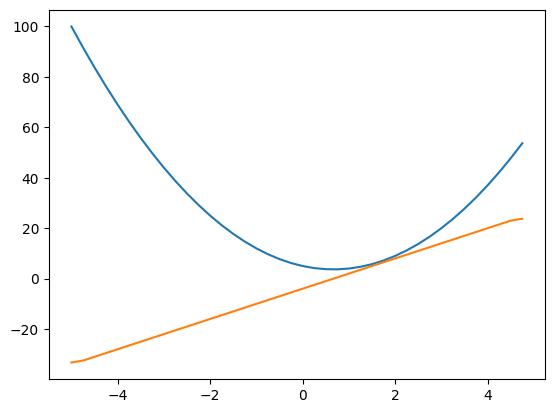

In [7]:
# plot derivative of function
plt.plot(xs, ys);
plt.plot(xs, np.gradient(ys, 0.25));

In [8]:
# multivariable equation
a = 2.0
b = -3.0 
c = 10.0
d = a*b + c
print(d)

4.0


In [9]:
# set small delta value
h = 0.0001

# get delta values for each variable
da = a + h
db = b + h
dc = c + h

# equations using delta values
da = da*b + c
db = a*db + c
dc = a*b + dc

# derivative function
def derive(f, fd, d):
    return (fd - f)/d

# test functions
dda = derive(d, da, h)
ddb = derive(d, db, h)
ddc = derive(d, dc, h)

print(dda)
print(ddb)
print(ddc)
print(round(dda, 1))
print(round(ddb, 1))
print(round(ddc, 1))

-3.000000000010772
2.0000000000042206
0.9999999999976694
-3.0
2.0
1.0


dda = b, ddb = a, ddc = CONSTANT

## Value Object

In [10]:
# define value class, attributes, and internal methods
class Value:
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data)
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data)
        return out

In [11]:
# create values
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

d = a*b + c # (a.__mul__(b)).__add__(c)
print(d)

Value(data=4.0)


In [12]:
# add children tracking
class Value:
    def __init__(self, data, _children=()):
        self.data = data
        self._prev = set(_children)

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other))
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other))
        return out

In [13]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

d = a*b + c
print(d)
print(d._prev)

Value(data=4.0)
{Value(data=10.0), Value(data=-6.0)}


In [14]:
# add operation
class Value:
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

In [15]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

d = a*b + c
print(d)
print(d._prev)
print(d._op)

Value(data=4.0)
{Value(data=-6.0), Value(data=10.0)}
+


In [16]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
e = a*b
d = e + c
f = Value(-2.0)
L = d * f
print(L)
print(L._prev)
print(L._op)

Value(data=-8.0)
{Value(data=4.0), Value(data=-2.0)}
*


In [17]:
# add gradient variable for saving node derivative from loss function
class Value:
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        self._prev = set(_children)
        self._op = _op

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

In [18]:
# add activation function (tanh)
class Value:
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        self._prev = set(_children)
        self._op = _op

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')


In [19]:
# add backpropagation functions
class Value:
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1-t**2) * out.grad
        out._backward = _backward    

        return out


In [20]:
# build topographical graph of nodes for backpropagation
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
# build_topo(o)

In [21]:
for node in reversed(topo):
    node._backward()

In [22]:
# add public backpropagation
class Value:
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op


    def __repr__(self):
        return f"Value(data={self.data})"


    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward

        return out


    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward

        return out


    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1-t**2) * out.grad
        out._backward = _backward    

        return out


    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


## Implementation in Pytorch

In [23]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('-----')
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())

0.7071066904050358
-----
x1 0.5000001283844369
w1 0.5000001283844369
x2 0.5000001283844369
w2 0.5000001283844369


## Creating The Neural Network Blueprint

In [24]:
class Neuron:

    def __init__(self, min):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(min)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

In [25]:
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

In [26]:
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [28]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
# n(x)

## Testing the Neural Network

In [29]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
] # inputs
ys = [1.0, -1.0, -1.0, 1.0] # targets